# Data Preparation

In [60]:
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timedelta
from notebook_utils import calculate_metrics, eval_metrics, timeseries_rel, trim_extremes, catplot_geo
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import geopandas as gpd
import json
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [39]:
# Styling Cell
sns.set_theme(context="notebook", style="whitegrid")

SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# To help with visualization, map proper names to the stats
stat_propers = {
    'mae': 'Mean Absolute Error',
    'rmse': 'Root Mean Absolute Error',
    'bias': 'Mean Forecast Bias',
    'corr': 'Correlation Coefficient',
    'skill_score': 'Skill Score'
}

## Historical Data Import

In [4]:
historical = pd.read_csv('../data/monterey_polygon_historical.csv', low_memory=False)
historical['time'] = pd.to_datetime(historical['time'])
historical

,field_id,crop,time,actual_et,actual_eto,actual_etof
0,CA_244000,47,2016-01-01,0.499,1.152,0.433
1,CA_244000,47,2016-01-02,0.641,1.466,0.437
2,CA_244000,47,2016-01-03,0.728,1.648,0.442
3,CA_244000,47,2016-01-04,0.520,1.166,0.446
4,CA_244000,47,2016-01-05,0.565,1.257,0.450
...,...,...,...,...,...,...
2371470,CA_258026,61,2024-12-10,1.129,1.186,0.952
2371471,CA_258026,61,2024-12-11,1.042,1.095,0.952
2371472,CA_258026,61,2024-12-12,1.129,1.186,0.952
2371473,CA_258026,61,2024-12-13,1.216,1.277,0.952


In [4]:
historical['time'].max()

Timestamp('2024-12-14 00:00:00')

In [5]:
historical['field_id'].nunique()

725

## Forecast Table Build

In [6]:
# Gather current forecast data for the county
forecasting_table = pd.DataFrame()
files = Path(f"../data/forecasts/fret/monterey/").glob("*.csv")

for file in files:
    parts = str(file.name).split("_")
    data = pd.read_csv(file, low_memory=False)
    data["forecasting_date"] = parts[2].split('.')[0]
    forecasting_table = pd.concat([data, forecasting_table], ignore_index=True)

forecasting_table['forecasting_date'] = pd.to_datetime(forecasting_table['forecasting_date'])
forecasting_table['time'] = pd.to_datetime(forecasting_table['time'])
forecasting_table = forecasting_table[~forecasting_table['fret_eto'].isna()]
forecasting_table

,field_id,crop,time,dtw_eto,fret_eto,forecasting_date,fret_et,fret_etof
304,CA_244000,47,2024-10-31,2.607,2.090,2024-10-30,NaN,NaN
305,CA_244000,47,2024-11-01,2.650,2.123,2024-10-30,NaN,NaN
306,CA_244000,47,2024-11-02,2.444,1.435,2024-10-30,NaN,NaN
307,CA_244000,47,2024-11-03,2.411,2.075,2024-10-30,NaN,NaN
308,CA_244000,47,2024-11-04,2.355,2.207,2024-10-30,NaN,NaN
...,...,...,...,...,...,...,...,...
2688581,CA_258026,61,2024-11-30,1.075,0.851,2024-11-28,NaN,NaN
2688582,CA_258026,61,2024-12-01,1.186,0.952,2024-11-28,NaN,NaN
2688583,CA_258026,61,2024-12-02,1.187,0.961,2024-11-28,NaN,NaN
2688584,CA_258026,61,2024-12-03,1.259,0.911,2024-11-28,NaN,NaN


In [7]:
forecasting_table = forecasting_table.drop_duplicates(subset=['field_id', 'forecasting_date', 'time'], keep='last')

## Main Table Merge

In [8]:
dt = historical.loc[(historical['time'].dt.year == 2024), :]

dt = dt.merge(forecasting_table, on=['field_id', 'crop', 'time'], how='inner').set_index(['forecasting_date', 'field_id', 'crop', 'time']).reset_index()
dt = dt.dropna(subset=['fret_eto'], how='all')
dt

,forecasting_date,field_id,crop,time,actual_et,actual_eto,actual_etof,dtw_eto,fret_eto,fret_et,fret_etof
0,2024-09-12,CA_244000,47,2024-09-12,2.799,5.173,0.541,NaN,3.710,2.961,0.798
1,2024-09-12,CA_244000,47,2024-09-13,2.605,5.315,0.490,NaN,3.850,2.372,0.616
2,2024-09-12,CA_244000,47,2024-09-14,2.743,6.246,0.439,NaN,3.320,2.178,0.656
3,2024-09-12,CA_244000,47,2024-09-15,2.537,6.535,0.388,NaN,2.820,1.960,0.695
4,2024-09-12,CA_244000,47,2024-09-16,1.565,4.014,0.390,NaN,2.740,2.008,0.733
...,...,...,...,...,...,...,...,...,...,...,...
69586,2024-12-04,CA_258026,61,2024-12-10,1.129,1.186,0.952,1.369,0.951,NaN,NaN
69587,2024-12-10,CA_258026,61,2024-12-11,1.042,1.095,0.952,1.277,1.102,NaN,NaN
69588,2024-12-10,CA_258026,61,2024-12-12,1.129,1.186,0.952,1.277,1.068,NaN,NaN
69589,2024-12-10,CA_258026,61,2024-12-13,1.216,1.277,0.952,1.387,0.944,NaN,NaN


## Unique Identifiers

In [9]:
forecast_dates = forecasting_table['forecasting_date'].unique()
fields = dt['field_id'].unique()
crops = dt['crop'].unique()

# Helpers
Below are functions that are being used to calculate data and generate plots.

The tables below are also calculated prior to speed up metric calculations.

### Average ET/ETo/ETof for 2024
This table will be used as a reference for any metric and plot calculations

In [10]:
avgs_table = pd.read_csv("../data/monterey_polygon_historical_2024_avgs.csv.csv", low_memory=False)
avgs_table

,field_id,crop,actual_et,actual_eto,actual_etof
0,CA_244000,47,2.298063,4.620885,0.501258
1,CA_244018,47,1.774252,4.404169,0.541453
2,CA_244025,47,2.086668,4.502527,0.450997
3,CA_244035,69,2.362367,4.566576,0.486610
4,CA_244053,47,1.503421,4.488178,0.417499
...,...,...,...,...,...
720,CA_257950,47,2.938536,4.268152,0.732023
721,CA_257978,47,1.472885,4.268152,0.444126
722,CA_257983,47,3.756315,4.293375,0.898542
723,CA_258017,47,3.373831,4.293375,0.738857


### Climatology Reference
The table below records the average conditions for each field for each day of the year.

In [11]:
climatology_table = pd.read_csv("../data/monterey_polygon_historical_climatology.csv", low_memory=False)
climatology_table

,field_id,crop,doy,actual_et,actual_eto,actual_etof
0,CA_244000,47,1,0.511111,0.918889,0.546000
1,CA_244000,47,2,0.565889,1.072000,0.542667
2,CA_244000,47,3,0.737333,1.302889,0.539444
3,CA_244000,47,4,0.741667,1.307556,0.536111
4,CA_244000,47,5,0.620333,1.207000,0.532778
...,...,...,...,...,...,...
265345,CA_258026,61,362,0.636125,1.014875,0.629000
265346,CA_258026,61,363,0.623875,1.003625,0.628125
265347,CA_258026,61,364,0.568500,0.912375,0.627250
265348,CA_258026,61,365,0.469000,0.752625,0.626250


# Calculation

In [12]:
def fret_error_calc(data: pd.DataFrame, **kwargs):
    # Data coming in is a DataFrame for each forecasting_date
    groups = data.groupby(['field_id', 'crop'])[["field_id", "crop", "time", "actual_eto", "fret_eto"]].apply(calculate_metrics, actual="actual_eto", expected="fret_eto", **kwargs).reset_index()

    return groups

In [13]:
analysis_end_date = historical['time'].max()

Est. run time: 21m

In [15]:
metrics_norm = (dt[(dt['time'] > dt['forecasting_date']) & (dt['time'] < (dt['forecasting_date']) + timedelta(days=7)) & (dt['time'] < analysis_end_date)]
                .groupby(['forecasting_date'])[list(dt.columns)]
                .apply(fret_error_calc, normalize=True, climatology_ref=climatology_table, avgs_ref=avgs_table))
metrics_norm.reset_index().to_csv('../data/metrics/monterey_fret_metrics_normalized.csv', index=False)

Failed to measure error metrics for field CA_245680
Found input variables with inconsistent numbers of samples: [5, 6]


/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rfishman/anaconda3/lib

OSError: Cannot save file into a non-existent directory: 'data/metrics'

In [16]:
metrics_norm.reset_index().to_csv('../data/metrics/monterey_fret_metrics_normalized.csv', index=False)

In [53]:
metrics_norm = pd.read_csv('../data/metrics/monterey_fret_metrics_normalized.csv').drop(['level_1'], axis=1)
metrics_norm['forecasting_date'] = pd.to_datetime(metrics_norm['forecasting_date'])

In [54]:
metrics_norm.head()

,forecasting_date,field_id,crop,mae,rmse,corr,bias,skill_score,c_mae,c_bias
0,2024-09-12,CA_244000,47,0.41,1.01,0.41,-0.41,-1.0,0.813833,NaN
1,2024-09-12,CA_244018,47,0.42,0.98,0.42,-0.42,-1.0,0.697333,NaN
2,2024-09-12,CA_244025,47,0.51,1.18,0.41,-0.51,-1.0,0.735130,NaN
3,2024-09-12,CA_244035,69,0.43,1.06,0.39,-0.43,-1.0,0.804889,NaN
4,2024-09-12,CA_244053,47,0.41,0.92,0.59,-0.41,-1.0,0.645778,NaN


# Visualization

In [55]:
# First reshape data from wide-form to long-form
metrics_long = metrics_norm.reset_index().melt(id_vars=['forecasting_date', 'field_id', 'crop'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')

In [56]:
# To help with visualization, map proper names to the stats
stat_propers = {
    'mae': 'Mean Absolute Error',
    'rmse': 'Root Mean Absolute Error',
    'bias': 'Mean Forecast Bias',
    'corr': 'Correlation Coefficient',
    'skill_score': 'Skill Score'
}
metrics_long['name'] = metrics_long['stat'].map(stat_propers)
metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30450 entries, 0 to 30449
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   forecasting_date  30450 non-null  datetime64[ns]
 1   field_id          30450 non-null  object        
 2   crop              30450 non-null  int64         
 3   stat              30450 non-null  object        
 4   value             30447 non-null  float64       
 5   name              30450 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 1.4+ MB


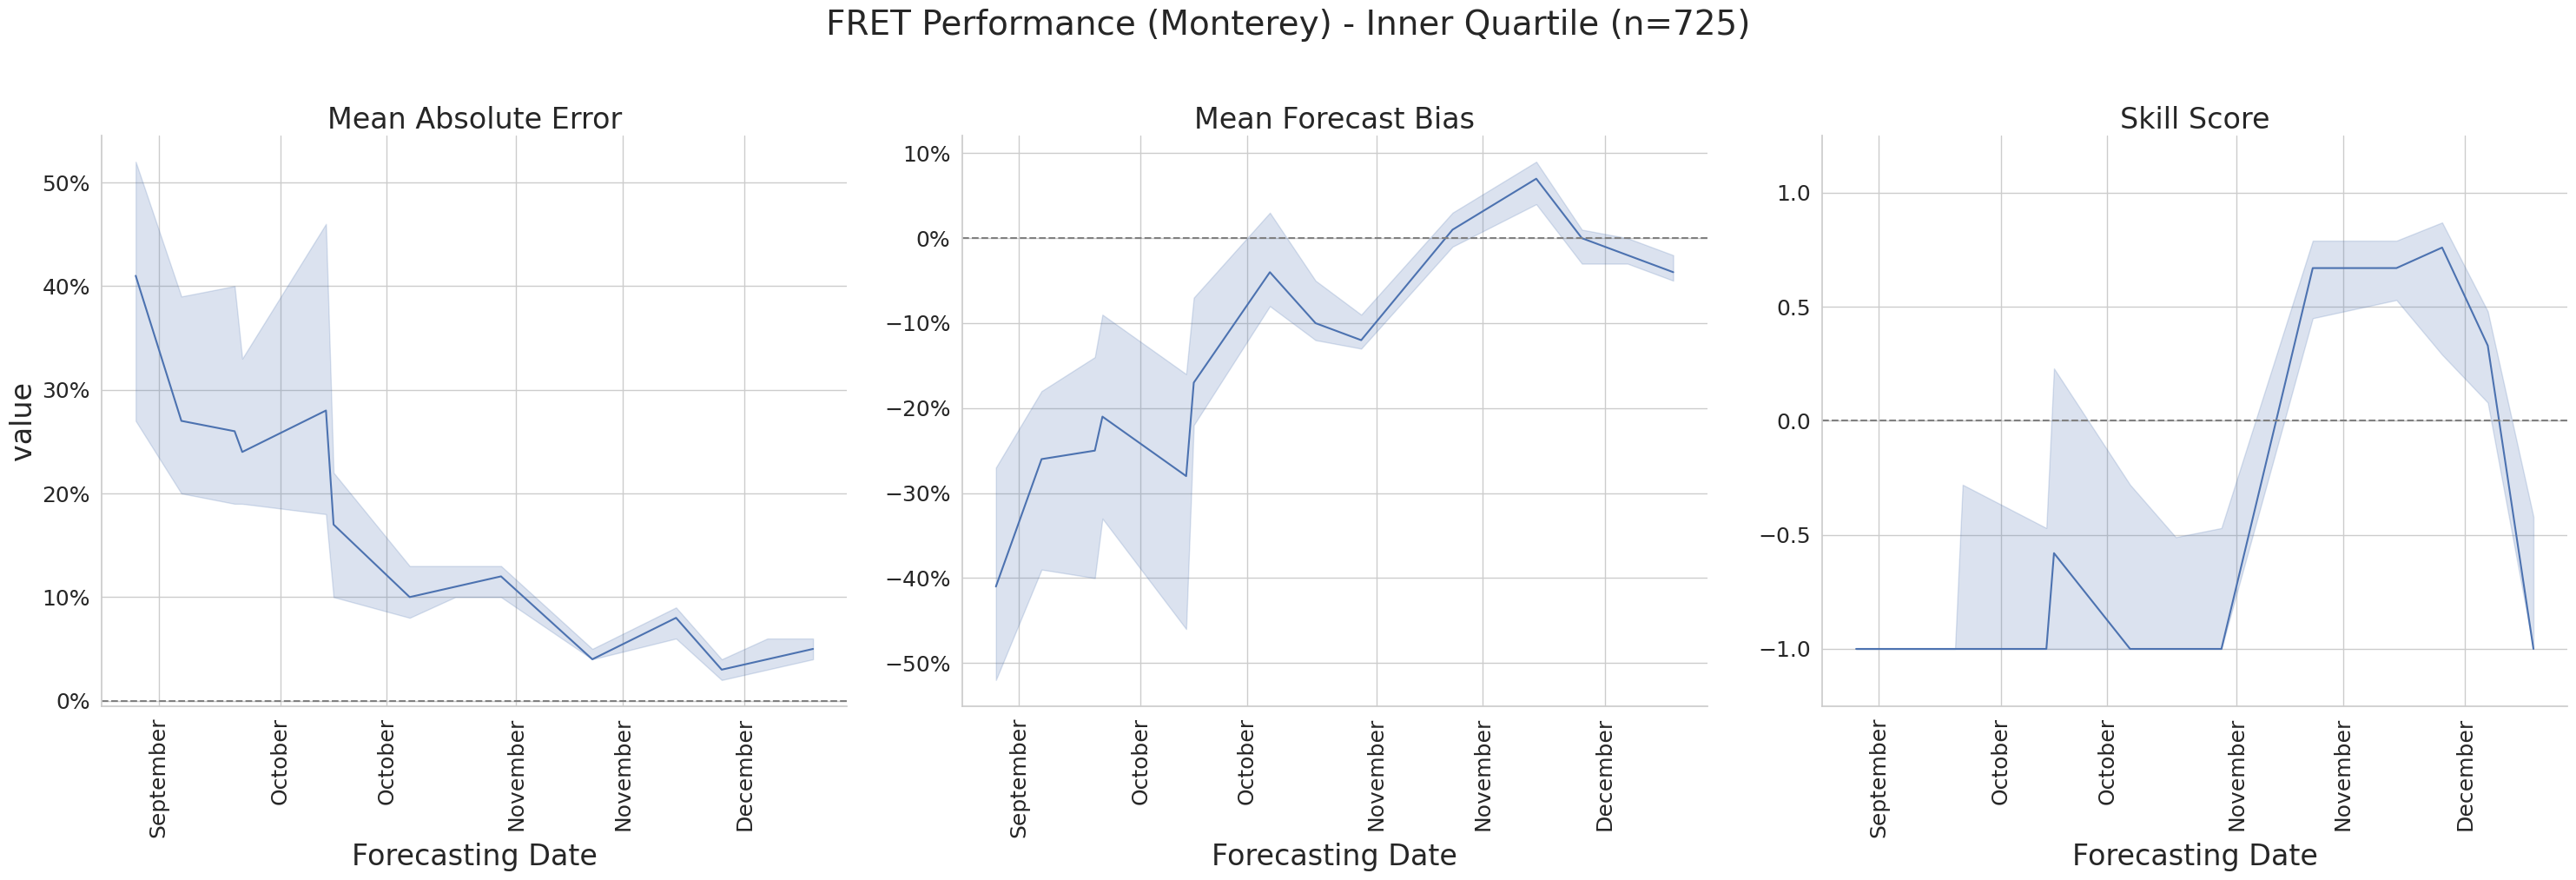

In [57]:
rel = timeseries_rel(metrics_long, col='name', y='value',
                     errorbar=('pi', 50), estimator=np.median, as_percent=True,
                     refline={'y': 0},
                     facet_kws={'sharey': False, 'margin_titles': True}, height=10,
                     title_template={"col_template":"{col_name}"},
                     title=f"FRET Performance (Monterey) - Inner Quartile (n={metrics_long['field_id'].nunique()})");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));

## Comparison to Dynamic Time Warping

In [58]:
dtw_metrics = pd.read_csv('../data/metrics/monterey_poly_metrics.csv', low_memory=False).drop(columns=['level_1', 'rmse', 'corr', 'c_mae', 'c_bias'])
dtw_metrics = dtw_metrics[dtw_metrics['variable'] == 'ETo']
dtw_metrics = dtw_metrics.drop(columns='variable')
dtw_metrics['forecasting_date'] = pd.to_datetime(dtw_metrics['forecasting_date'])

# Filters out dates not in FRET.
dtw_metrics = dtw_metrics[(dtw_metrics['forecasting_date'] >= fret_metrics['forecasting_date'].min()) & (dtw_metrics['forecasting_date'] <= fret_metrics['forecasting_date'].max())]

dtw_metrics['method'] = 'dtw'
dtw_metrics.head()

,forecasting_date,field_id,crop,mae,bias,skill_score,method
5950,2024-09-16,CA_244113,47,0.17,0.04,-1.00,dtw
5951,2024-09-16,CA_244148,69,0.17,-0.02,-1.00,dtw
5952,2024-09-16,CA_244387,61,0.32,0.32,-0.96,dtw
5953,2024-09-16,CA_244429,47,0.28,0.28,-1.00,dtw
5954,2024-09-16,CA_244437,47,0.24,0.24,-1.00,dtw


In [23]:
fret_metrics = metrics_norm[metrics_norm['field_id'].isin(dtw_metrics['field_id'].unique())].drop(columns=['rmse', 'corr', 'c_mae', 'c_bias'])
fret_metrics.loc[:, 'method'] = 'fret'
fret_metrics.head()

,forecasting_date,field_id,crop,mae,bias,skill_score,method
10,2024-09-12,CA_244113,47,0.45,-0.45,-1.00,fret
11,2024-09-12,CA_244148,69,0.22,-0.19,-0.82,fret
25,2024-09-12,CA_244387,61,0.28,-0.25,-0.30,fret
28,2024-09-12,CA_244437,47,0.46,-0.46,-1.00,fret
31,2024-09-12,CA_244479,47,0.25,-0.24,-0.46,fret


In [43]:
overview_cmp = pd.concat([dtw_metrics, fret_metrics])
overview_cmp

,forecasting_date,field_id,crop,mae,bias,skill_score,method
5950,2024-09-16,CA_244113,47,0.17,0.04,-1.00,dtw
5951,2024-09-16,CA_244148,69,0.17,-0.02,-1.00,dtw
5952,2024-09-16,CA_244387,61,0.32,0.32,-0.96,dtw
5953,2024-09-16,CA_244429,47,0.28,0.28,-1.00,dtw
5954,2024-09-16,CA_244437,47,0.24,0.24,-1.00,dtw
...,...,...,...,...,...,...,...
10132,2024-12-10,CA_257648,47,0.07,-0.07,-1.00,fret
10134,2024-12-10,CA_257714,47,0.04,-0.02,0.17,fret
10136,2024-12-10,CA_257744,47,0.06,-0.06,-1.00,fret
10137,2024-12-10,CA_257756,47,0.04,-0.04,-1.00,fret


In [44]:
overview_cmp_long = overview_cmp.melt(id_vars=['forecasting_date', 'field_id', 'crop', 'method'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')

/home/rfishman/anaconda3/envs/python311/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/rfishman/anaconda3/envs/python311/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/rfishman/anaconda3/envs/python311/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


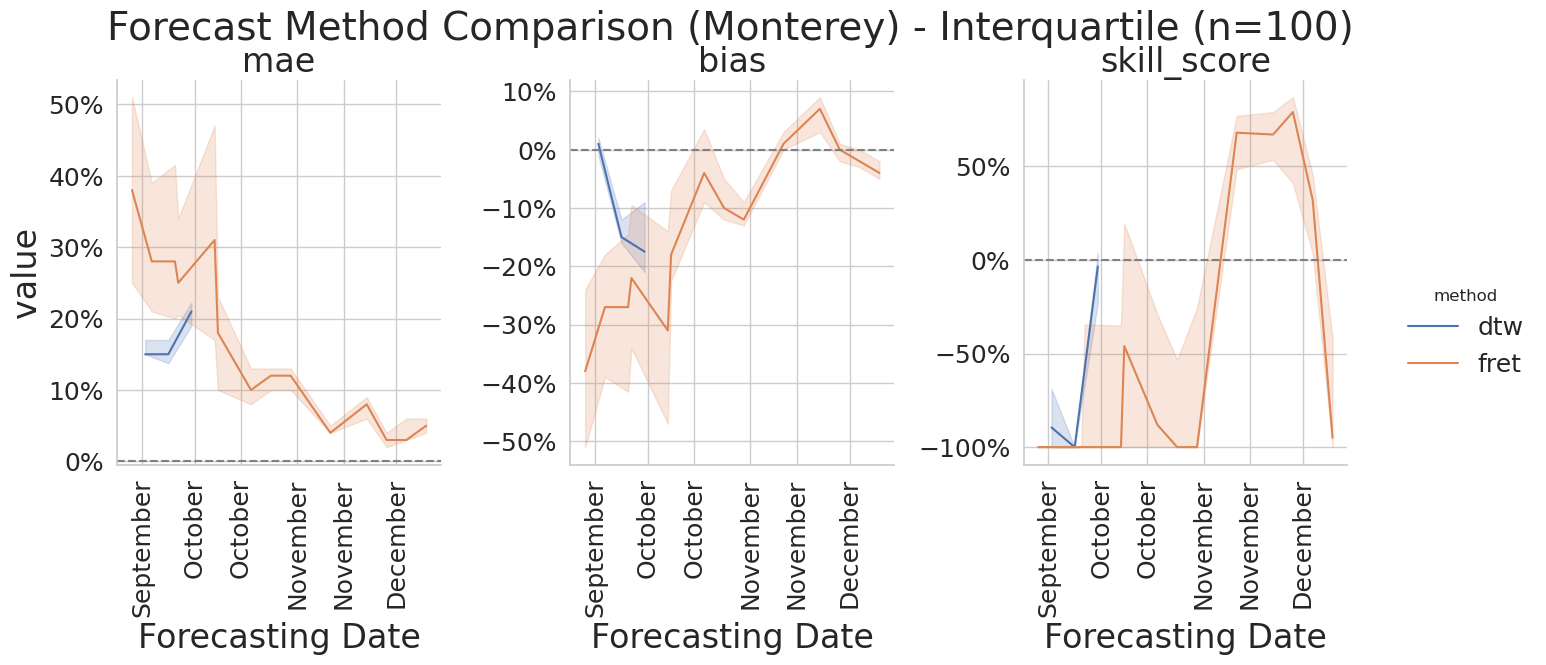

In [51]:
rel = timeseries_rel(overview_cmp_long, y='value', plot='rel', kind='line',
                     col='stat', hue='method',
                     refline={'y': 0},
                     facet_kws={'sharey': False, 'margin_titles': True, 'gridspec_kws':{'wspace': 0.4, 'hspace': 0.2}}, 
                     estimator=np.median, errorbar=('pi', 50), 
                     title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title=f"Forecast Method Comparison (Monterey) - Interquartile (n={overview_cmp_long['field_id'].nunique()})", 
                     as_percent=True);

## Spatial Plotting

### Data Building

In [61]:
# Import table using only field and hectare columns
field_metadata = pd.read_json('../data/geo/field_metadata.json')[['field_id', 'hectares']]
# Reformat field IDs to be same convention as the other tables.
field_metadata['field_id'] = 'CA_' + field_metadata['field_id'].astype(str).str[1:]
field_metadata = field_metadata.set_index('field_id')
field_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 729 entries, CA_244000 to CA_258026
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   hectares  729 non-null    float64
dtypes: float64(1)
memory usage: 11.4+ KB


In [62]:
# Add additional data to the data table
points = pd.read_csv("../data/Monterey.csv", low_memory=False).set_index("OPENET_ID").rename_axis("field_id")

# Expand .geo column into lon, lat columns
geo = (points[".geo"]
                .apply(lambda x: pd.Series(dict(json.loads(x))))['coordinates']
                .apply(lambda x: pd.Series(list(x), index=['longitude', 'latitude'])))
geo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 739 entries, CA_253578 to CA_251078
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  739 non-null    float64
 1   latitude   739 non-null    float64
dtypes: float64(2)
memory usage: 17.3+ KB


In [63]:
# Combine all forecasts for each field by getting mean of forecast metrics.
geo_metrics = metrics_long.groupby(['field_id', 'name'])[['value']].agg('mean').round(2)

# Add positional columns
geo_metrics = geo_metrics.join(geo, how='left', on='field_id', validate='many_to_one')
# Add field size column for marker size
geo_metrics = geo_metrics.join(field_metadata, how='left', on='field_id', validate='many_to_one')
# Calculate marker size
geo_metrics['markersize'] = geo_metrics.apply(lambda x: np.max(np.divmod(x['hectares'] / 10, 10)[1], initial=2.0), axis=1)

geo_metrics.reset_index(inplace=True)
geo_metrics.dropna(inplace=True)
geo_metrics

,field_id,name,value,longitude,latitude,hectares,markersize
0,CA_244000,Mean Absolute Error,0.16,-121.540540,36.537255,263.816,6.3816
1,CA_244000,Mean Forecast Bias,-0.13,-121.540540,36.537255,263.816,6.3816
2,CA_244000,Skill Score,-0.38,-121.540540,36.537255,263.816,6.3816
3,CA_244018,Mean Absolute Error,0.16,-121.539709,36.547528,164.326,6.4326
4,CA_244018,Mean Forecast Bias,-0.15,-121.539709,36.547528,164.326,6.4326
...,...,...,...,...,...,...,...
2170,CA_258017,Mean Forecast Bias,-0.17,-121.651532,36.646953,15.124,2.0000
2171,CA_258017,Skill Score,-0.52,-121.651532,36.646953,15.124,2.0000
2172,CA_258026,Mean Absolute Error,0.14,-121.485852,36.463501,7.117,2.0000
2173,CA_258026,Mean Forecast Bias,-0.12,-121.485852,36.463501,7.117,2.0000


In [65]:
county_line = gpd.read_file('../data/geo/MoCo_Boundary.geojson')
county_line

,FID,PERIMETER,COUNTY,SHAPE_AREA,SHAPE_LEN,geometry
0,1,1903900,MONTEREY CO,9.239835e+10,2.155890e+06,"POLYGON ((-121.69858 36.9167, -121.70104 36.91..."


### Plotting

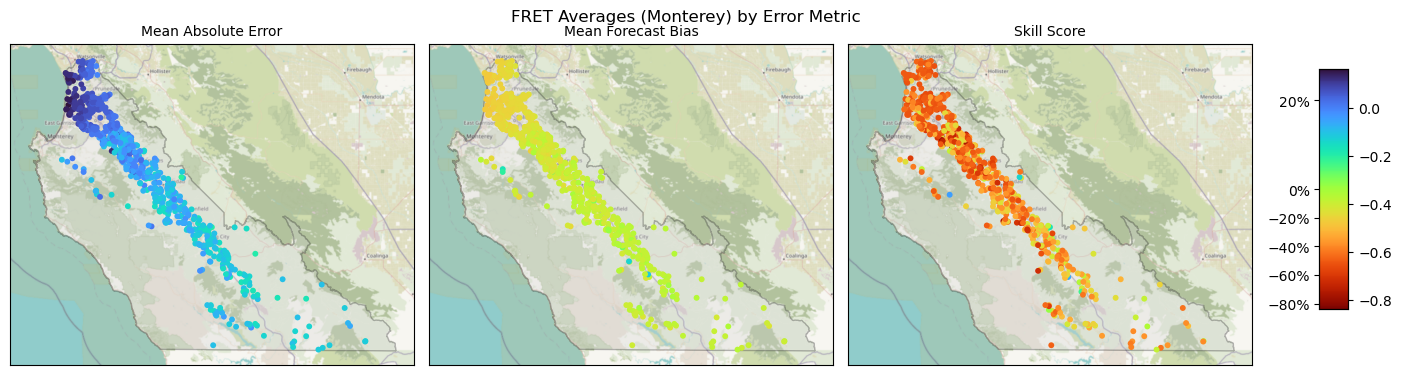

In [66]:
# For double legend
geo_ss = geo_metrics[geo_metrics['name'] == 'Skill Score']

catplot_geo(geo_metrics, boundary_map=county_line, col='name', hue='value', double_legend=geo_ss,
            title='FRET Averages (Monterey) by Error Metric', export_img='../images/monterey/fret_spatial_averages.png',
            background=True, normalize_cmap=True, palette='turbo_r',
            title_template={"template":"{col_name}"}, );